# Scenario 3
For scenario 3, from the description: "Explore the space of closely related models (structurally speaking) that incorporate either deaths, hospitalizations, or both.". For this purpose, models 958 and 960 are relevant.

In [10]:
# Get models 958 and 960
from mira.sources.biomodels import get_template_model

model_958 = get_template_model("BIOMD0000000958")
model_960 = get_template_model("BIOMD0000000960")

# Save the petrinet version of the models
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel
petri_958 = PetriNetModel(Model(model_958))
petri_960 = PetriNetModel(Model(model_960))
for mname, model in [("scenario3_biomd958.json", petri_958), ("scenario3_biomd960.json", petri_960)]:
    model.to_json_file(mname, indent=1)
# Also dump the mira model jsons
with open("scenario3_biomd958_mira.json", "w") as f:
    f.write(model_958.json(indent=1))
with open("scenario3_biomd960_mira.json", "w") as f:
    f.write(model_960.json(indent=1))

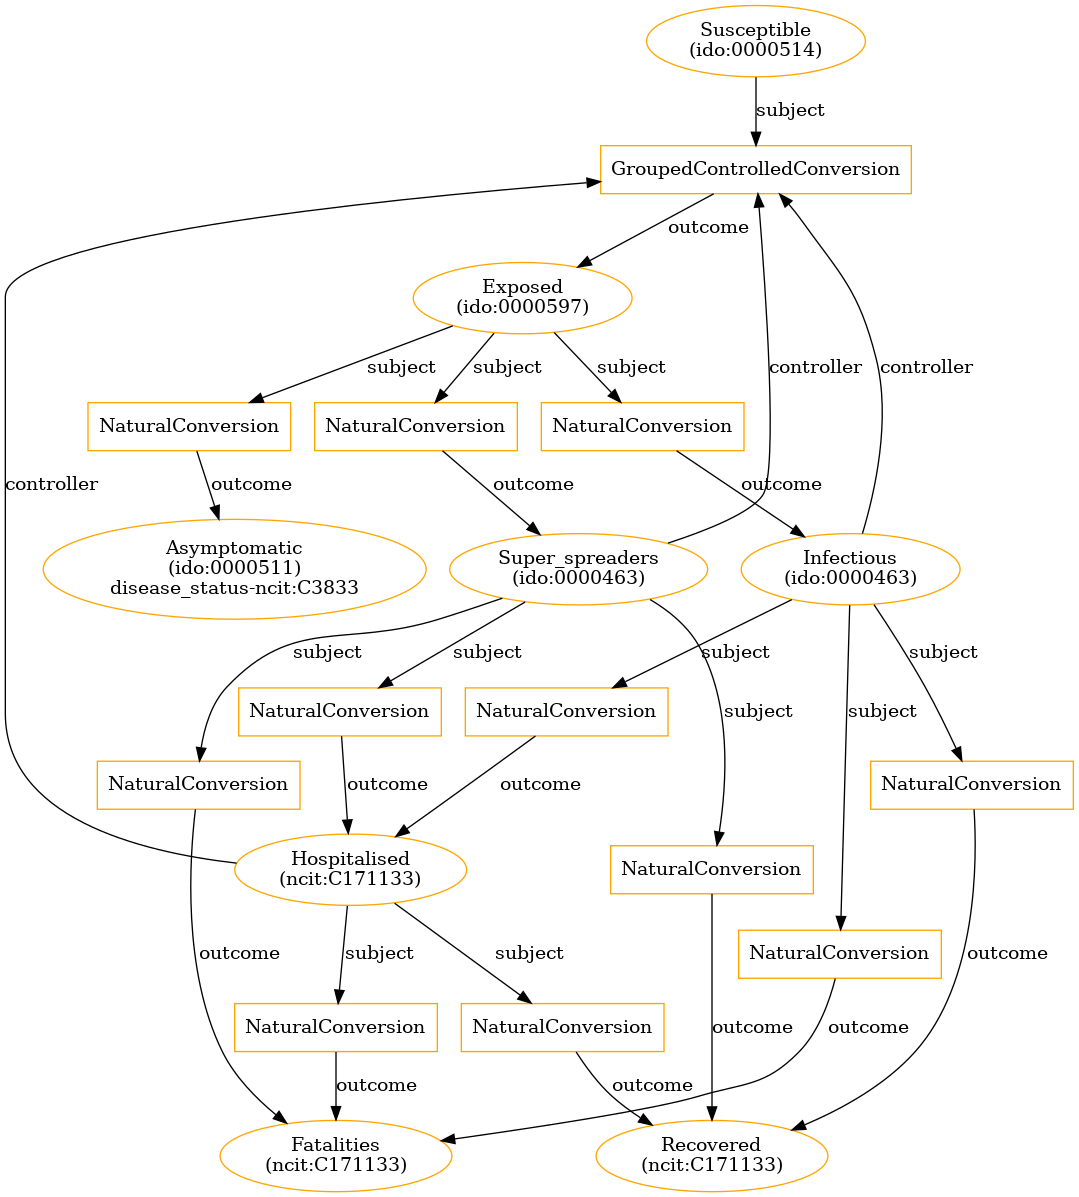

In [11]:
# Check out the models
from IPython.display import Image
model_958.draw_graph("sc3_model_958.png")
Image(filename="sc3_model_958.png")

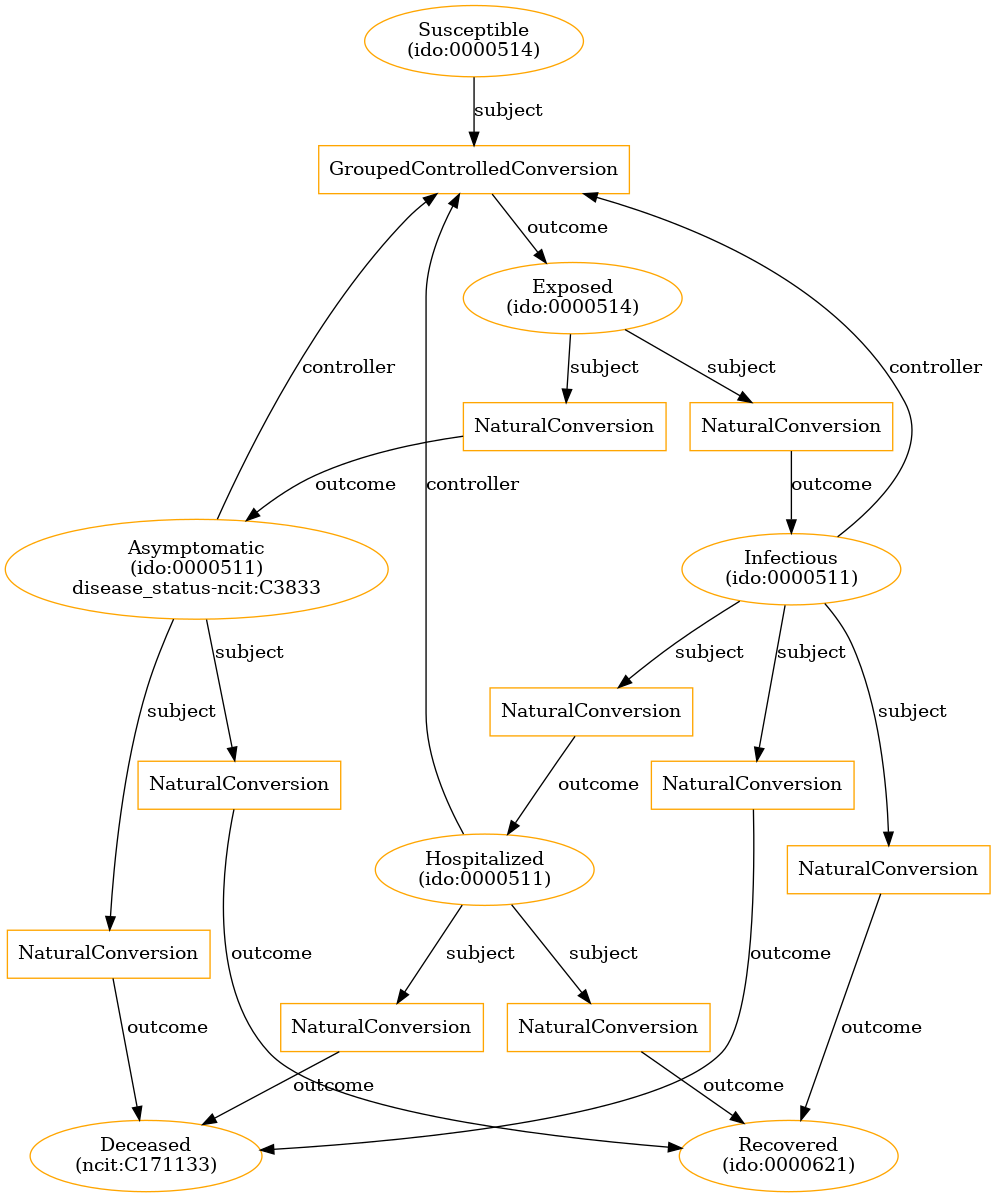

In [12]:
model_960.draw_graph("sc3_model_960.png")
Image(filename="sc3_model_960.png")

In [14]:
# Compare the models
from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel import TemplateModelDelta
tmd = TemplateModelDelta(model_958, model_960, refinement_function=is_ontological_child_web)
tmd.draw_graph("sc3_model_958_960_delta.png", args="-Grankdir=TB")

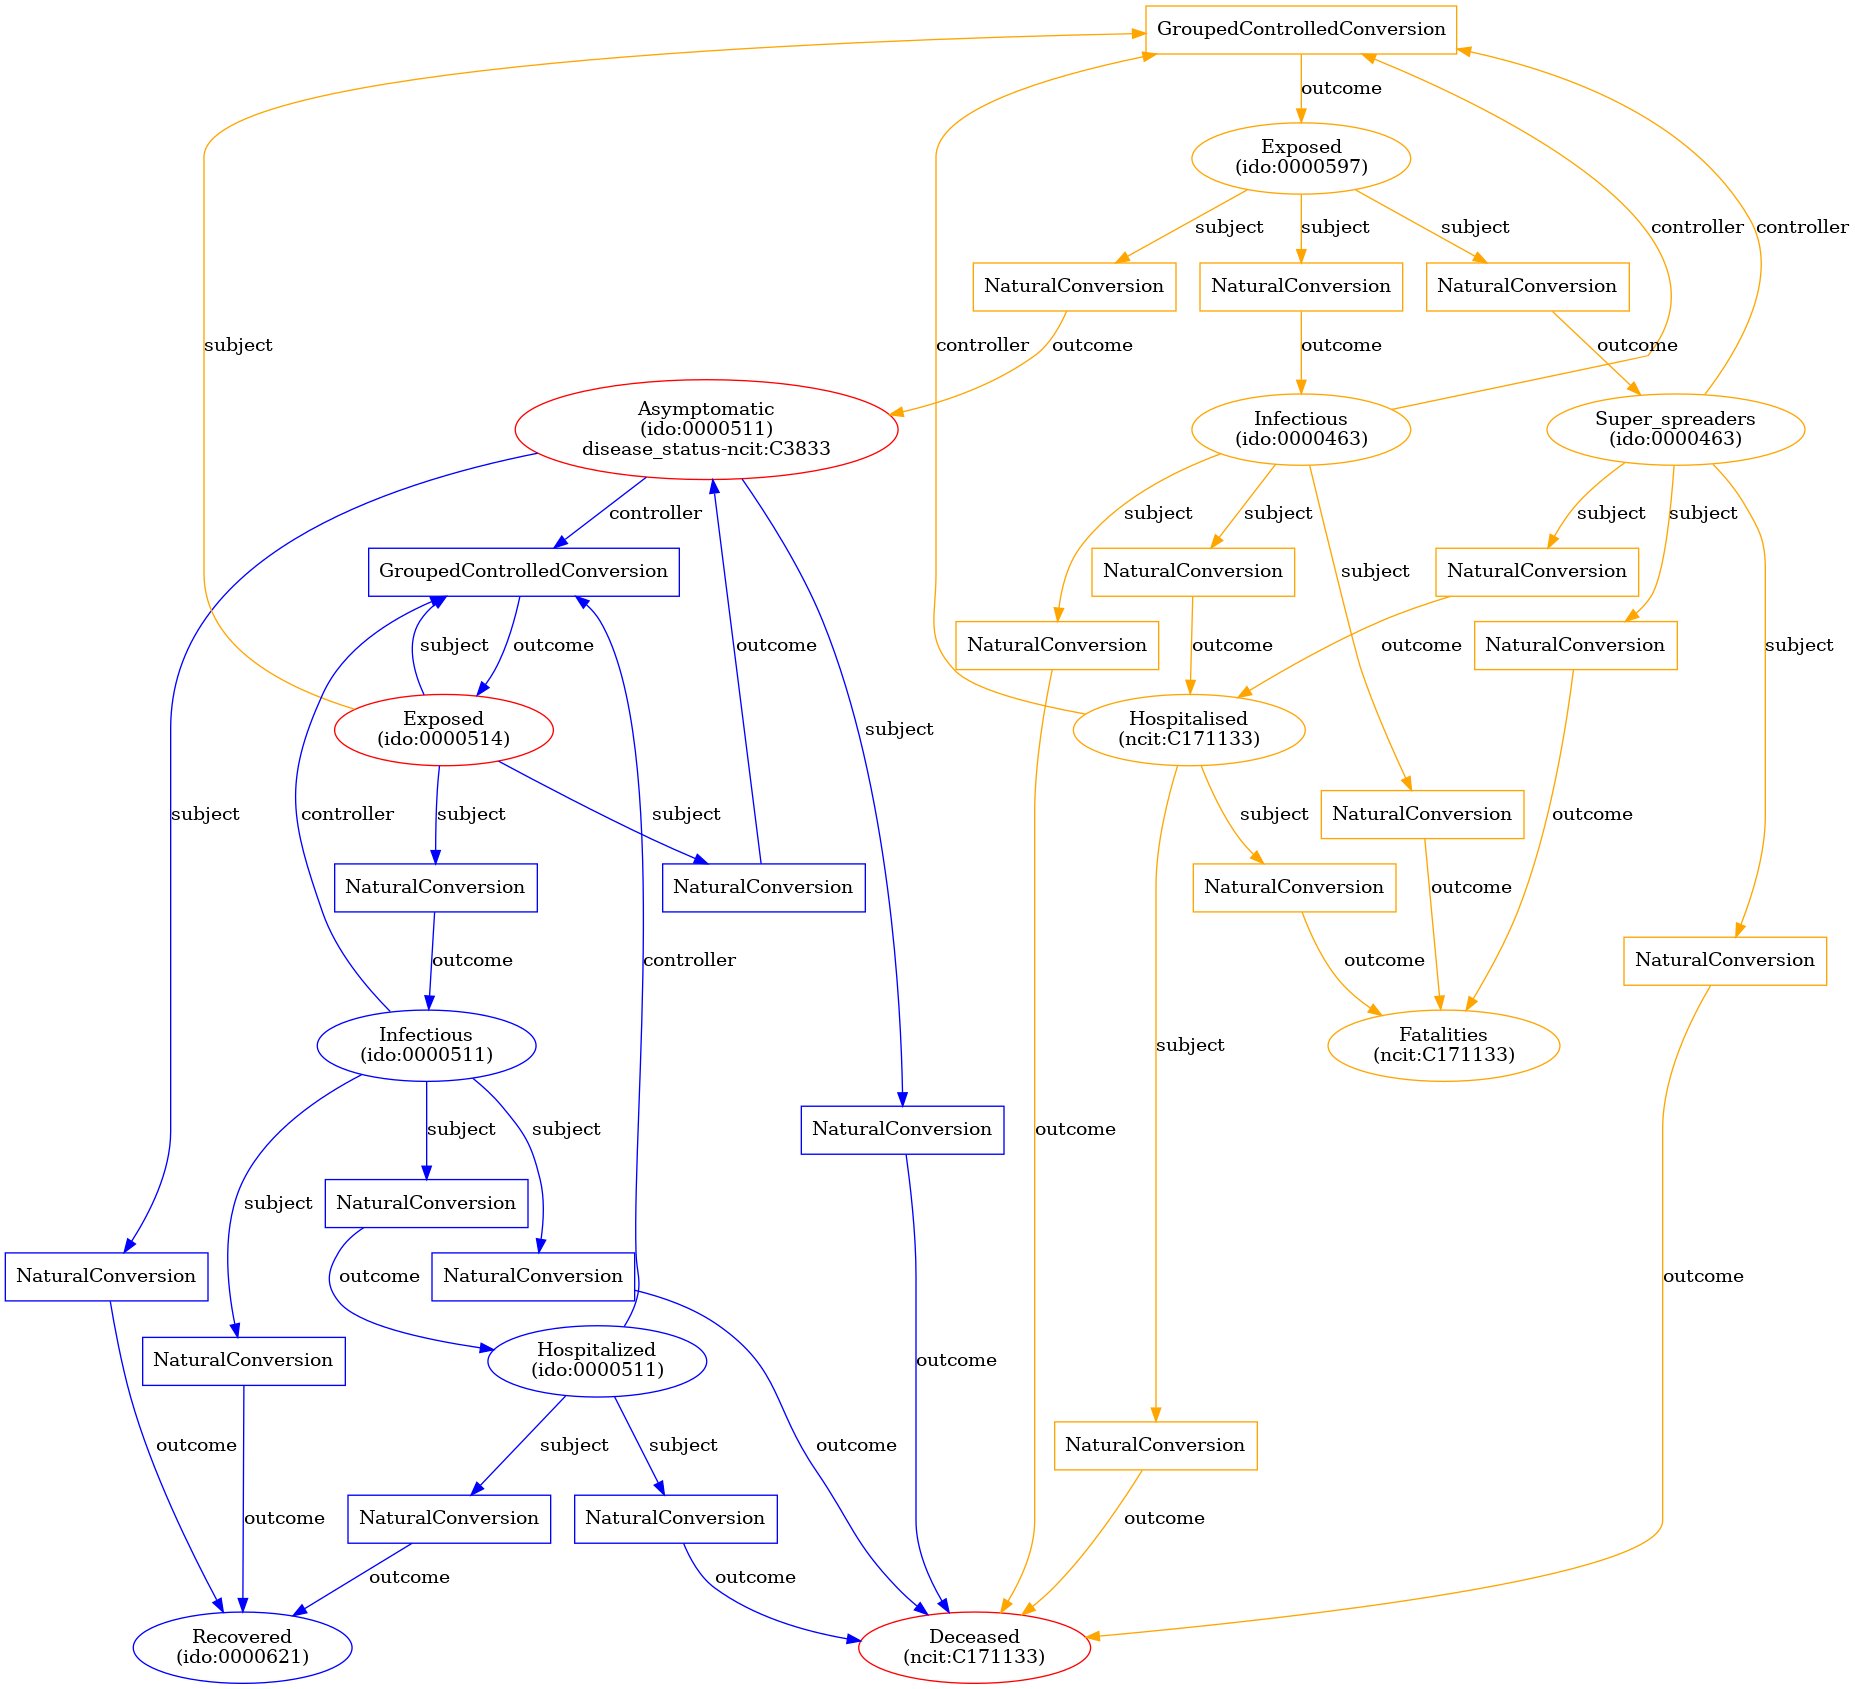

In [15]:
Image(filename="sc3_model_958_960_delta.png")

As can be seen in the graph above, the exposed node is gone and, instead is seems to have been merged with the exposed node. Fatalities and Deceased are not merged, Deceased is instead merged with a recovery node. Let's look at the data associated with the concepts in the models:

In [16]:
lookup_dict = {"958": {}, "960": {}}
for model_name, model in [("958", model_958), ("960", model_960)]:
    for template in model.templates:
        for concept in template.get_concepts():
            if concept.name not in lookup_dict[model_name]:
                lookup_dict[model_name][concept.name] = concept

for model_name in lookup_dict:
    print('------')
    for conc_name, conc in lookup_dict[model_name].items():
        print(model_name, conc_name, conc.identifiers, conc.get_curie_str(), "context:", conc.context or "(none)")


------
958 Infectious {'ncit': 'C171133', 'ido': '0000463'} ido:0000463 context: (none)
958 Hospitalised {'ncit': 'C171133'} ncit:C171133 context: (none)
958 Super_spreaders {'ncit': '0000511', 'ido': '0000463'} ido:0000463 context: (none)
958 Susceptible {'ncit': 'C171133', 'ido': '0000514'} ido:0000514 context: (none)
958 Exposed {'ncit': 'C171133', 'ido': '0000597'} ido:0000597 context: (none)
958 Asymptomatic {'ncit': 'C171133', 'ido': '0000511'} ido:0000511 context: {'disease_status': 'ncit:C3833'}
958 Fatalities {'ncit': 'C171133'} ncit:C171133 context: (none)
958 Recovered {'ncit': 'C171133'} ncit:C171133 context: (none)
------
960 Infectious {'ncit': 'C171133', 'ido': '0000511'} ido:0000511 context: (none)
960 Asymptomatic {'ncit': 'C171133', 'ido': '0000511'} ido:0000511 context: {'disease_status': 'ncit:C3833'}
960 Hospitalized {'ncit': 'C168447', 'ido': '0000511'} ido:0000511 context: (none)
960 Susceptible {'ncit': 'C171133', 'ido': '0000514'} ido:0000514 context: (none)
96

## Human in the loop intervention
As can be seen in the output above, several concepts have vague identification and need to be better annotated in order to disambiguate them. The human in the loop intervention needed is "simulated" by the following mapping:

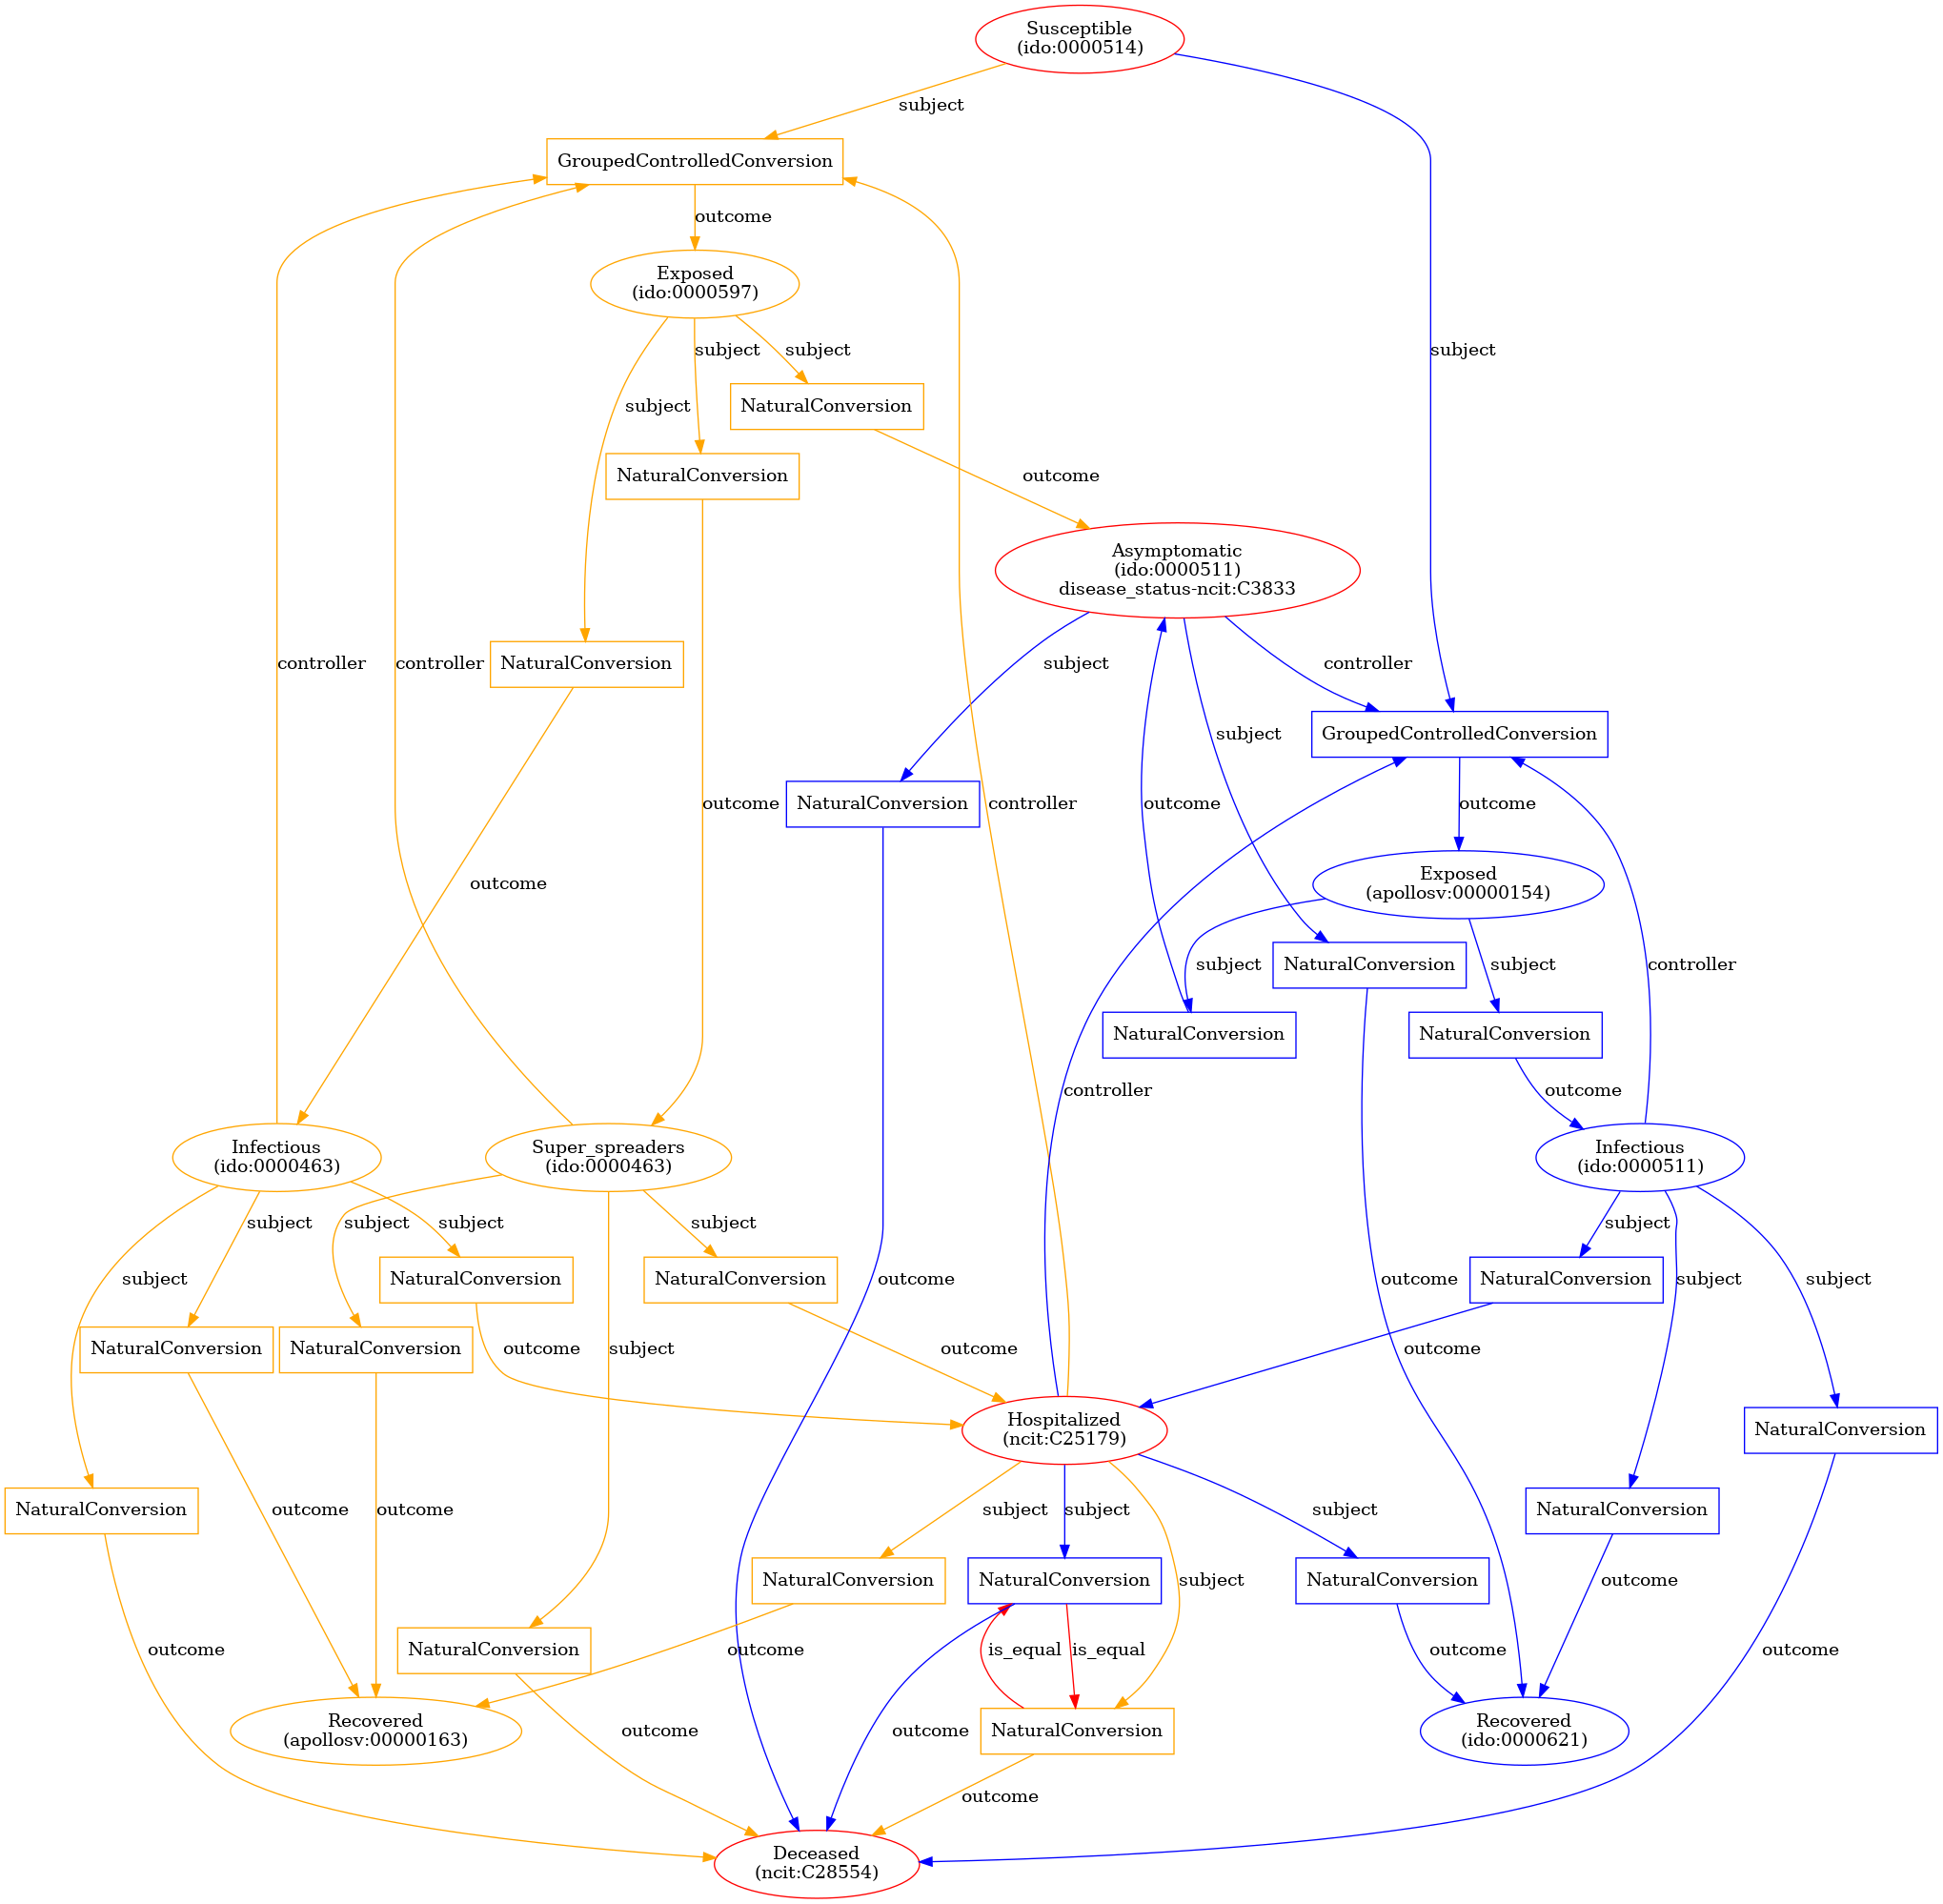

In [ ]:
from mira.metamodel import Concept

# Identifiers seen here:
# ncit:C171133 (covid-19 infection) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C171133
# ncit:C28554 (death) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C28554
# ncit:C25179 (hospitalization) https://ncit.nci.nih.gov/ncitbrowser/ConceptReport.jsp?dictionary=NCI%20Thesaurus&code=C25179
# apollosv:00000163 (Recoverd Population) https://ontobee.org/ontology/APOLLO_SV?iri=http://purl.obolibrary.org/obo/APOLLO_SV_00000163
# ido:0000511 (infected population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000511
# ido:0000514 (susceptible population) https://www.ebi.ac.uk/ols/ontologies/ido/terms?obo_id=IDO:0000514

concept_mapping = {
    "958": {

        "Fatalities": Concept(name="Fatalities",
                              identifiers={"ncit": "C28554"}),
        "Hospitalised": Concept(name="Hospitalised",
                                identifiers={"ncit": "C25179"}),
        "Recovered": Concept(name="Recovered",
                             identifiers={"apollosv": "00000163"}),
    },
    "960": {
        "Exposed": Concept(name="Exposed",
                           identifiers={"apollosv": "00000154"}),
        "Deceased": Concept(name="Deceased",
                            identifiers={"ncit": "C28554"}),
        "Infectious": Concept(name="Infectious",
                              identifiers={"ido": "0000511", "apollosv": "00000163"}),
        "Hospitalized": Concept(name="Hospitalized",
                                identifiers={"ncit": "C25179"})
    }
}

# Map the concepts from previous
for template_958 in model_958.templates:
    for concept in template_958.get_concepts():
        if concept.name in concept_mapping["958"]:
            concept.identifiers = concept_mapping["958"][concept.name].identifiers

for template_960 in model_960.templates:
    for concept in template_960.get_concepts():
        if concept.name in concept_mapping["960"]:
            concept.identifiers = concept_mapping["960"][concept.name].identifiers

# Now test the comparison again
tmd_corr = TemplateModelDelta(model_958, model_960, refinement_function=is_ontological_child_web)
tmd_corr.draw_graph("sc3_model_958_960_delta_corrected.png", args="-Grankdir=TB")
Image(filename="sc3_model_958_960_delta_corrected.png")


## Add vaccination
We now need to add vaccination to the two models

In [ ]:
import sympy
from mira.examples.concepts import vaccinated
from mira.metamodel import NaturalConversion

# Get the susceptible Concepts from each of the models
susceptible_958 = None
for template in model_958.templates:
    if template.name == "GroupedControlledConversion":
        susceptible_958 = template.subject
        break
assert susceptible_958 is not None

susceptible_960 = None
for template in model_960.templates:
    if template.name == "GroupedControlledConversion":
        susceptible_960 = template.subject
        break
assert susceptible_960 is not None

# todo: add vaccination to the models
vaccination_rate = sympy.parse_expr("")
vaccination_conversion_958 = NaturalConversion(subject=susceptible_958, outcome=vaccinated, )
vaccination_conversion_960 = NaturalConversion(subject=susceptible_960, outcome=vaccinated, )

## Add reinfection
We're asked to add reinfection to the model. This is done by adding a new template to the model. The template is a `NaturalConversion` from `recovered` to `susceptible` or `recovered` straight to `infected`.